In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_4_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_4_crimes_500m                                          0.000000   
                                                 pre_treatment_change_in_group_4_crimes_500m                                         0.003997   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                                  0.013332   
                                                 job_density_2013                                                                    0.380971   
                                                 med_hhinc2016                                                                       0.000297   
                                                 poor_share2010                                                                      0.048858   
                                                 popdensity2010                                                                      0.002528   
Panel C: Case Initiation                         for_cause                                                                           0.128813   
                                                 no_cause                                                                            0.662445   
                                                 non_payment                                                                         0.158860   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                            0.490038   
                                                 hasAttyP                                                                            0.438575   
                                                 isEntityD                                                                           0.595381   
                                                 isEntityP                                                                           0.198546   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_4_crimes_500m      2.349770e-01  
                                                 pre_treatment_change_in_group_4_crimes_500m     5.798140e-02  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              8.133641e-01  
                                                 job_density_2013                                5.501121e-01  
                                                 med_hhinc2016                                   1.427126e-02  
                                                 poor_share2010                                  4.904136e-03  
                                                 popdensity2010                                  6.737331e-01  
Panel C: Case Initiation                         for_cause                                       5.801068e-03  
                                                 no_cause                                        3.431724e-02  
                                                 non_payment                                     3.013004e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                        2.406617e-08  
                                                 hasAttyP                                

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 4 Incidents, 2017                       3.280628   
        $\Delta$ Group 4 Incidents, 2017-2019               1.035602   
Panel B Bachelor's degree, 2010                             0.316407   
        Median household income, 2016                   47553.063874   
        Poverty rate, 2010                                  0.279638   
        Population density, 2010                        23320.185868   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 4 Incidents, 2017                                    -1.140353   
        $\Delta$ Group 4 Incidents, 2017-2019                            -0.435788   
Panel B Bachelor's degree, 2010                                           0.002512   
        Median household income, 2016                                  2997.870414   
        Poverty rate, 2010                                               -0.021030   
        Population density, 2010                                       -297.766413   

                                                                               
                                               \emph{p}    Weighted  \emph{p}  
Panel A Total Group 4 Incidents, 2017          0.234977   -0.146202  0.874799  
        $\Delta$ Group 4 Incidents, 2017-2019  0.057981   -0.052886  0.798740  
Panel B Bachelor's degree, 2010                0.813364   -0.004108  0.696853  
        Median household income, 2016          0.014271 -384.649367  0.647644  
        Poverty rate, 2010                     0.004904   -0.005696  0.366824  
        Population density, 2010               0.673733 -345.673962  0.626528

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:08<00:00, 134.97it/s]


0.008415481404339724
0.05018117751116309
0.04566098699446914
0.08596658915502799


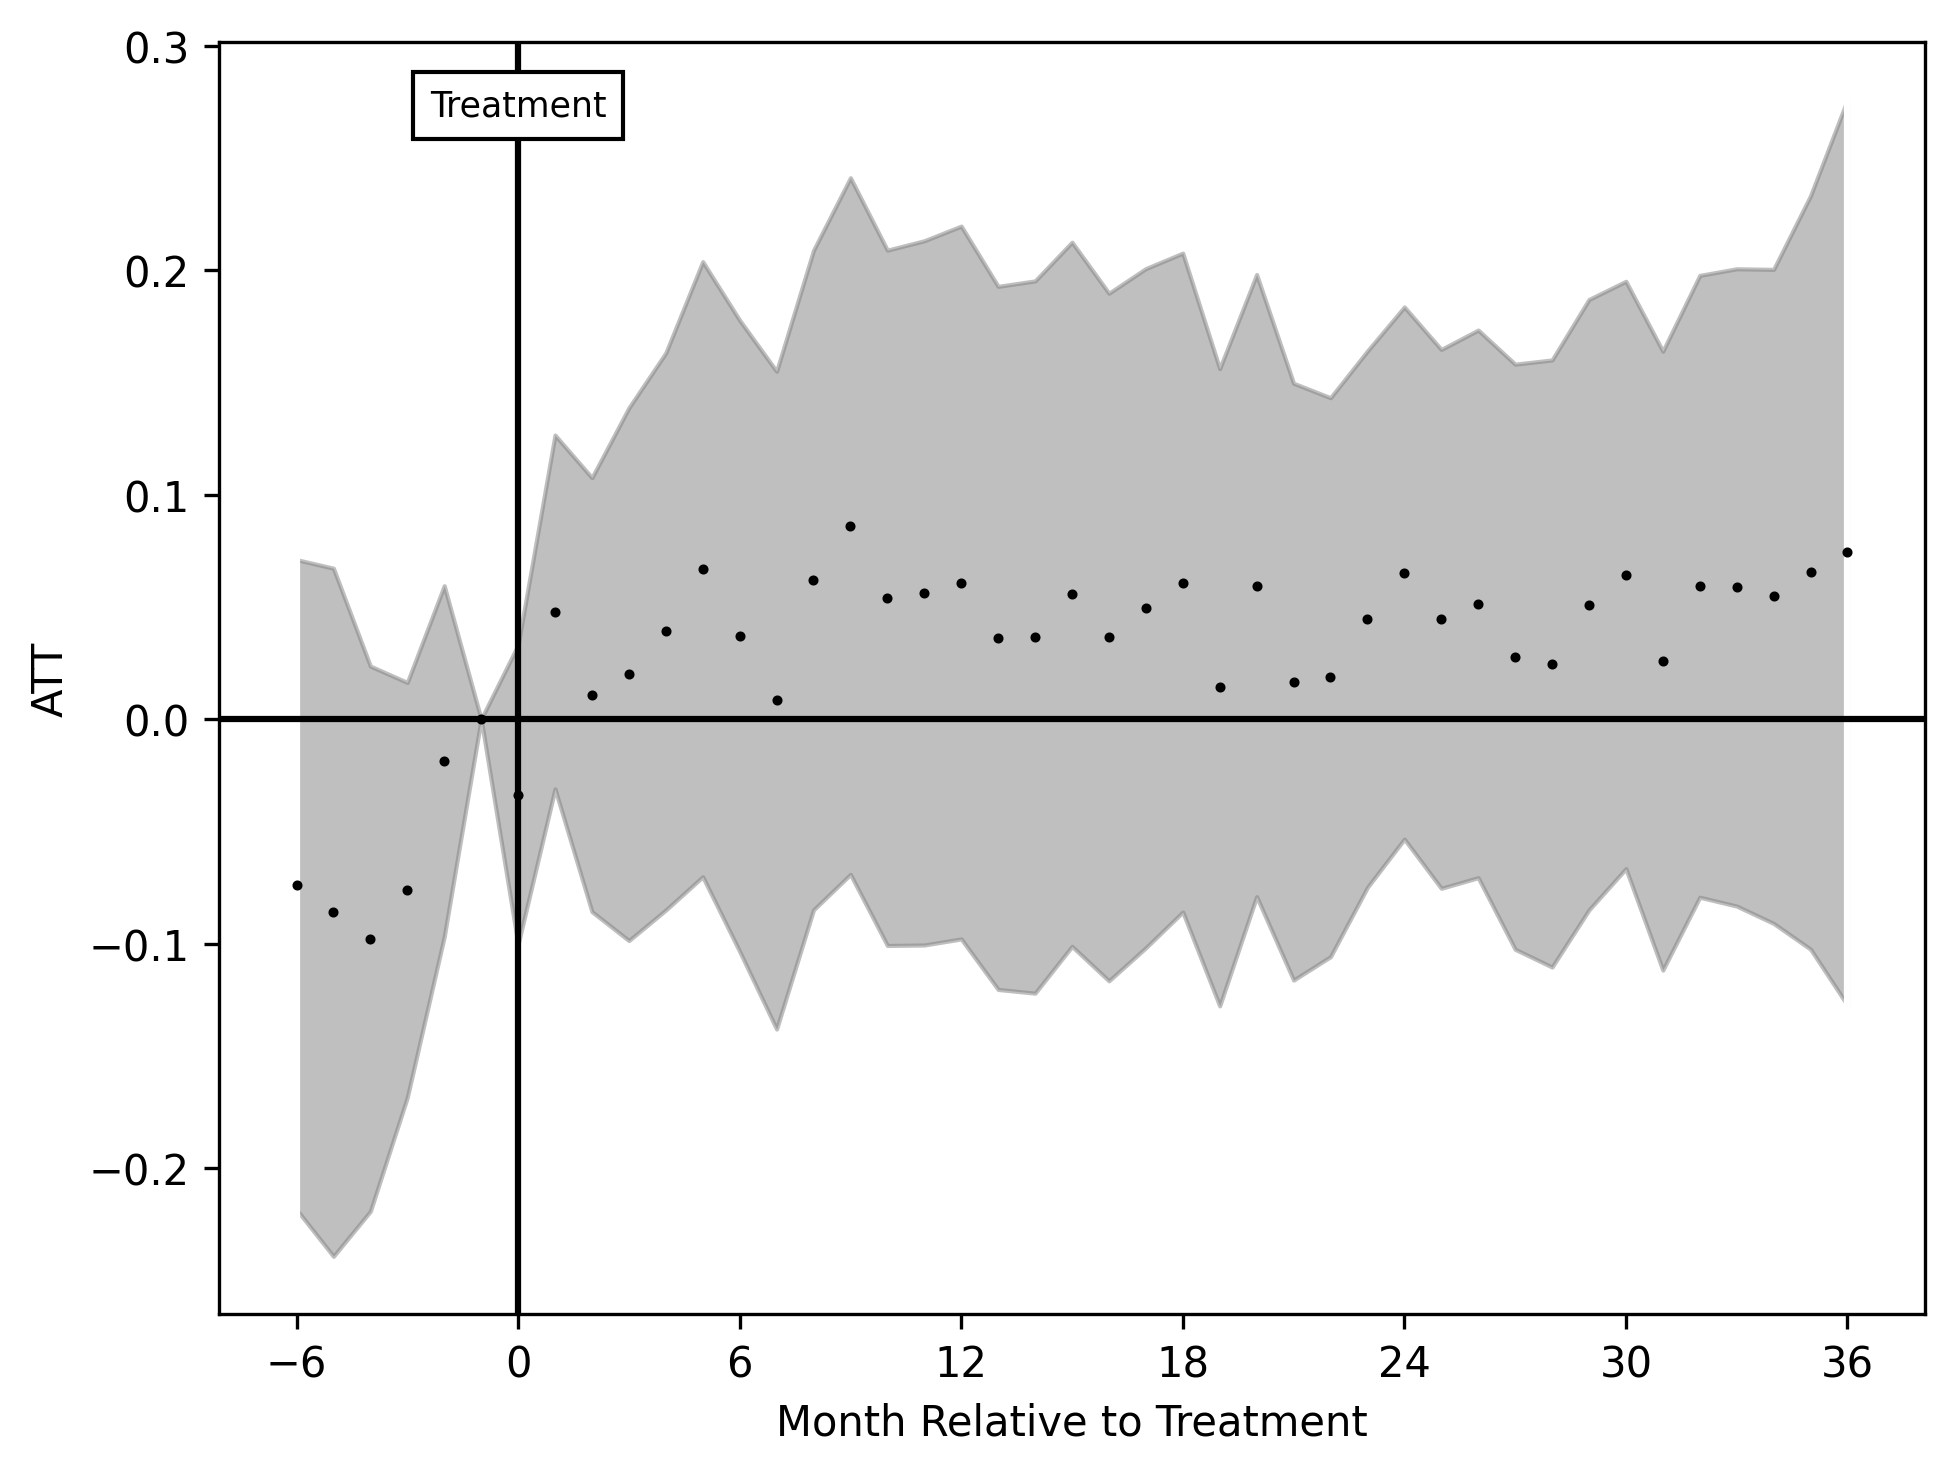

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [8]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:10<00:00, 104.82it/s]


-0.0142414968831421
0.008001174008696084
0.010496003315025282
0.05490829033553435


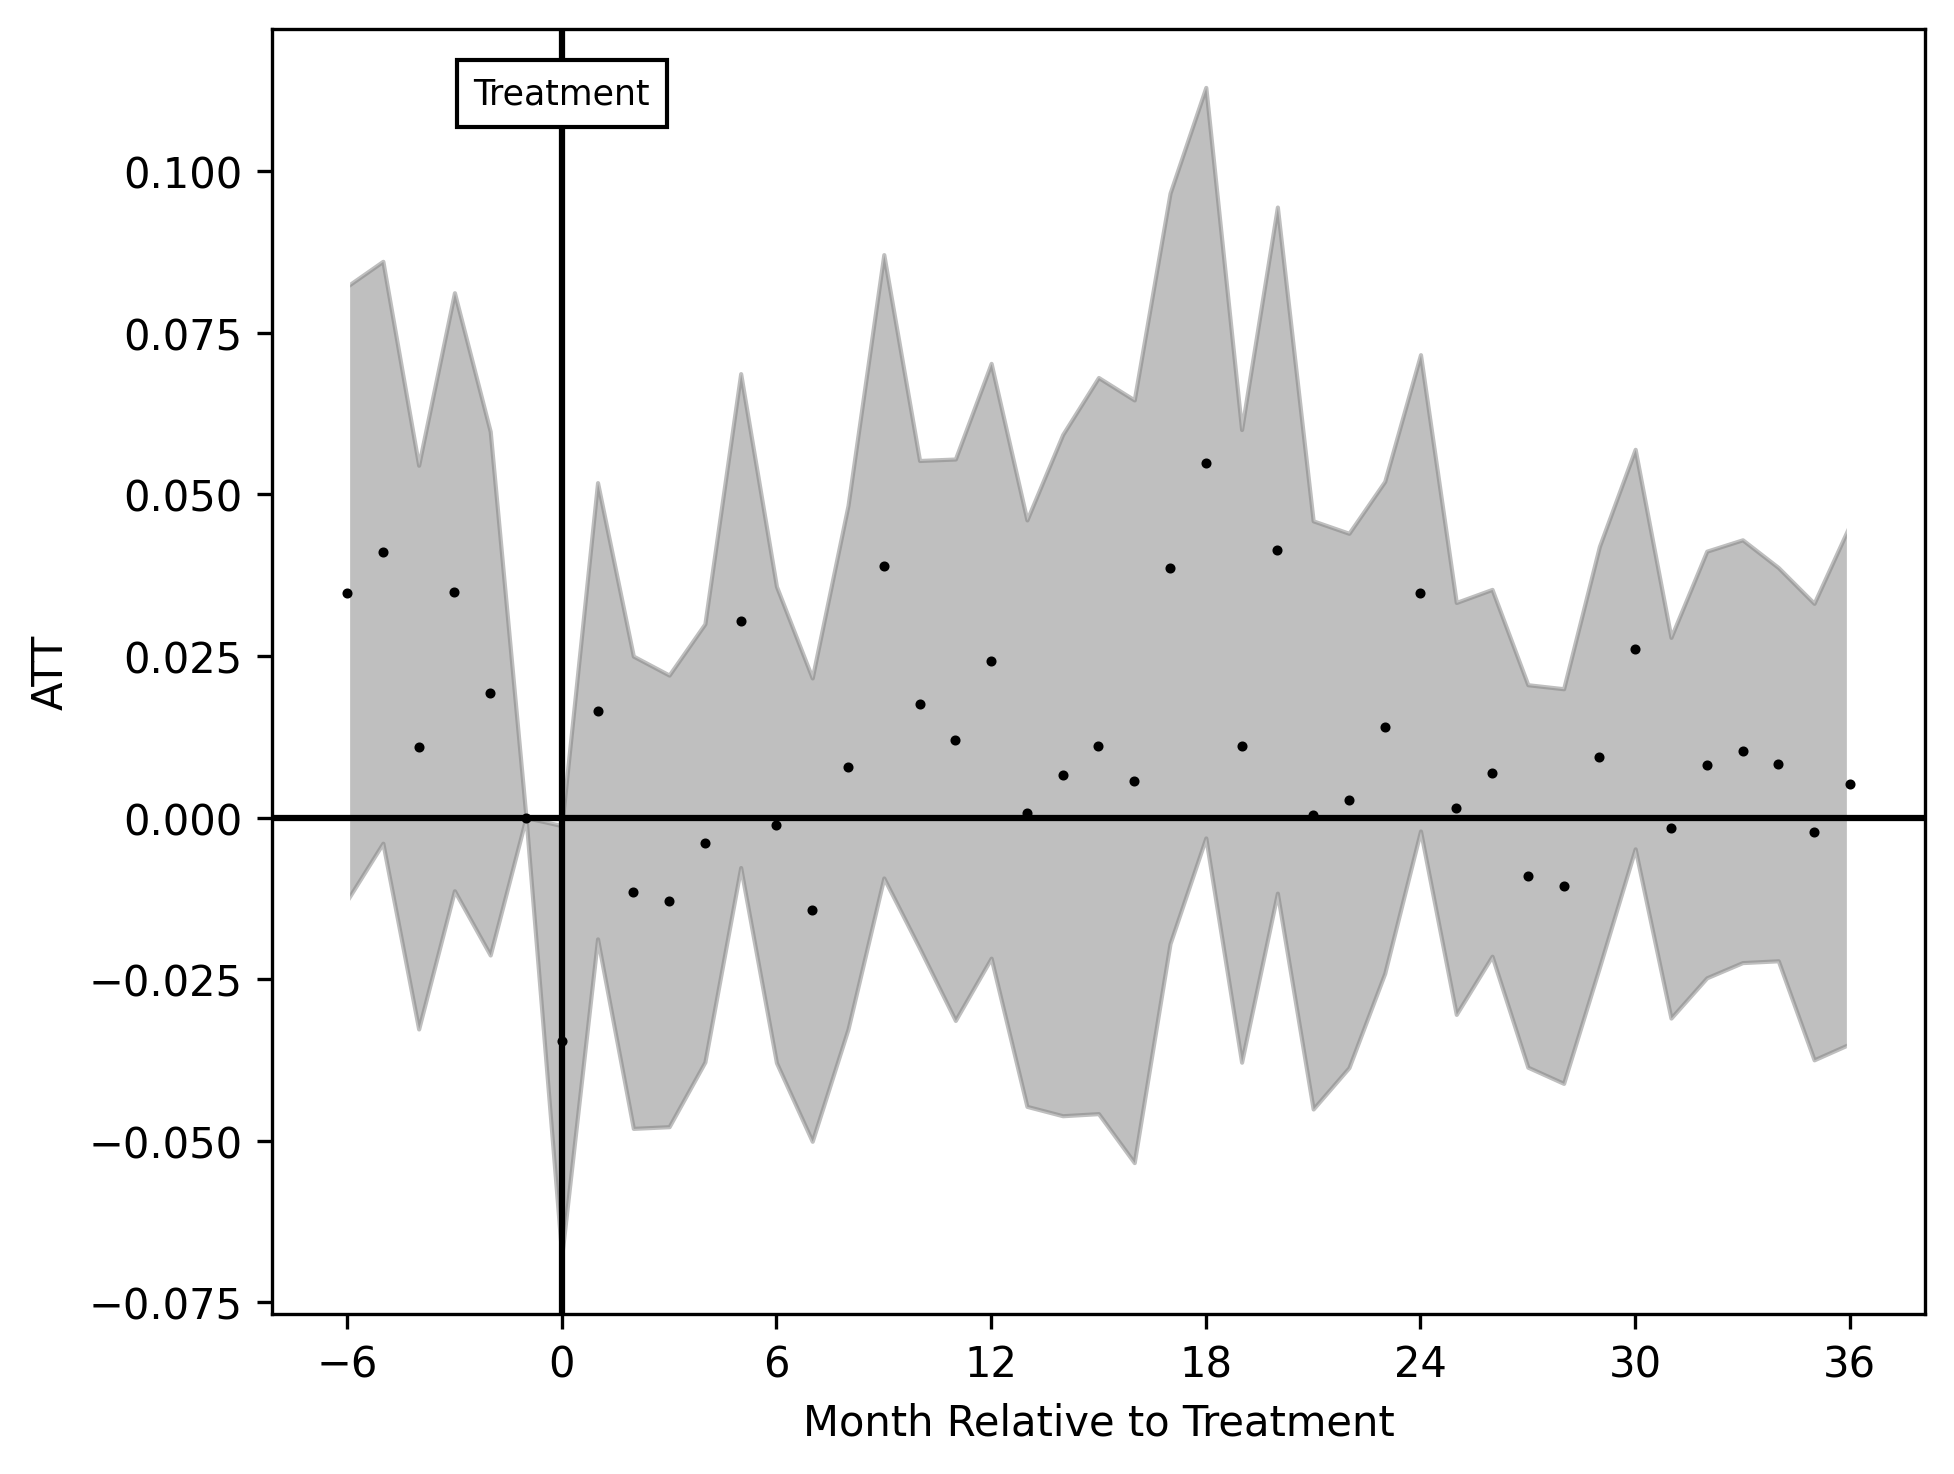

In [9]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)